In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

from sklearn.model_selection import GroupKFold
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
df_all_clean = pd.read_csv("correctness_all_clean.csv")


### GAZE + FIXATION + NLP

Chance Results:
Avg Accuracy: 0.66
Avg Weighted F1 Score: 0.66
Avg Precision_1: 0.79
Avg Recall_1: 0.79
Avg AUROC: 0.50
Avg Confusion Matrix:
[[ 54.8 212.6]
 [211.6 782.8]]
Avg Prediction Rate: 0.79

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Random Forest Results:
Avg Accuracy: 0.67
Avg Weighted F1 Score: 0.69
Avg Precision_1: 0.83
Avg Recall_1: 0.72
Avg AUROC: 0.64
Avg Confusion Matrix:
[[124.4 143. ]
 [274.  720.4]]
Avg Prediction Rate: 0.68

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, t

<Figure size 1100x700 with 0 Axes>

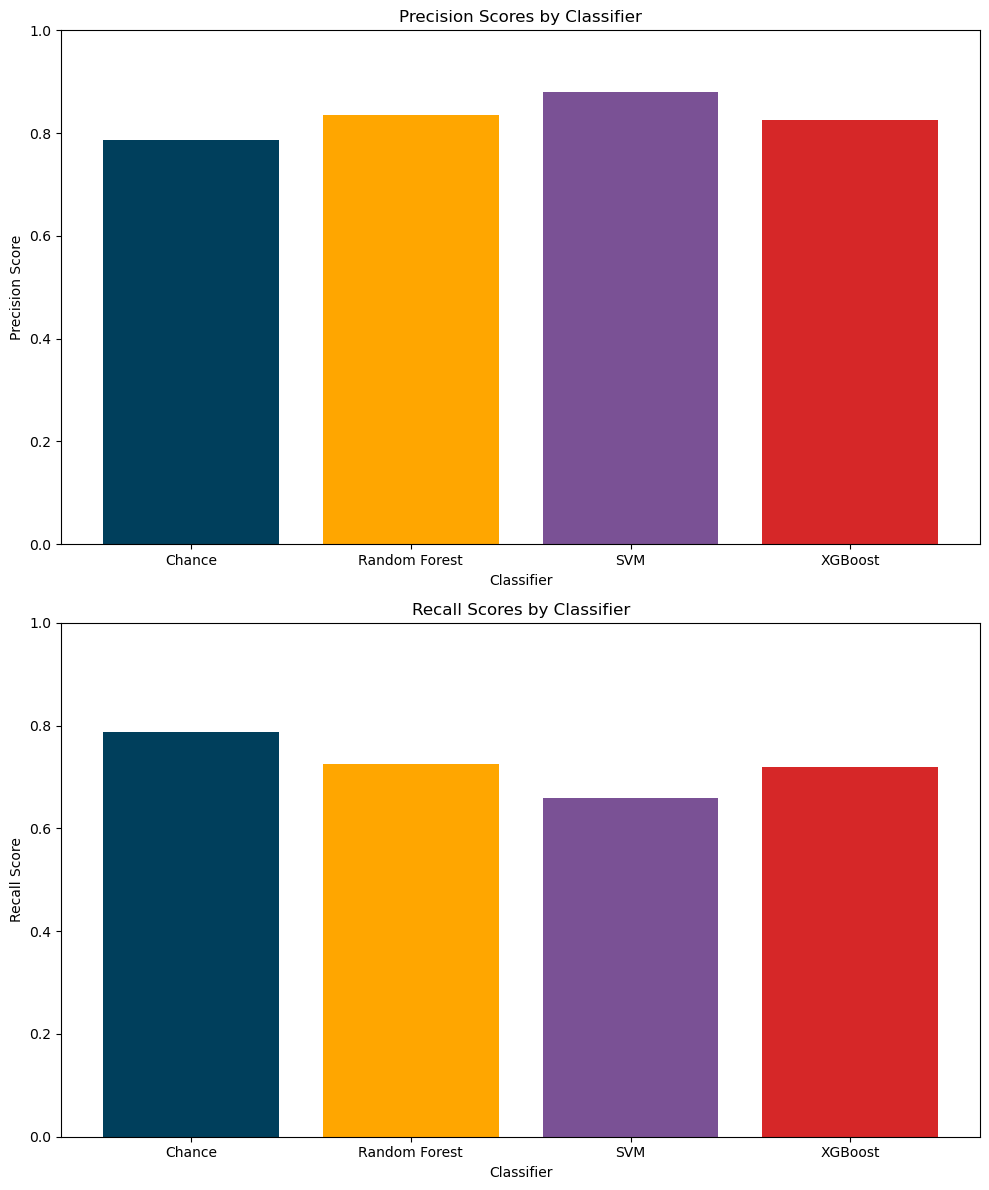

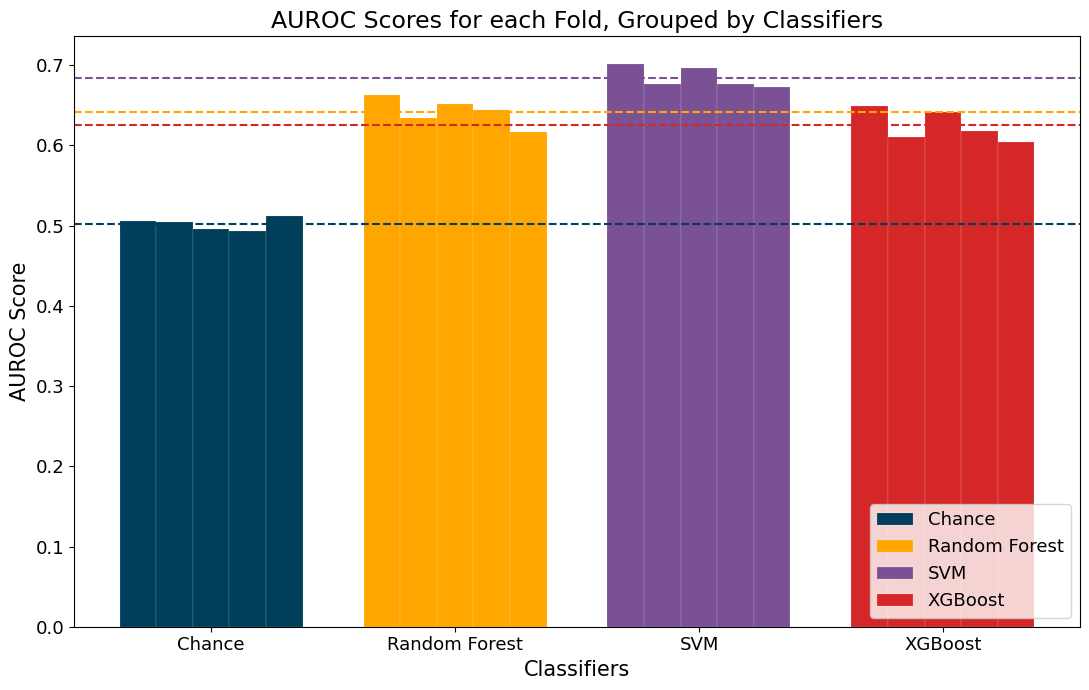

In [3]:
#AUROC
# Preparing the data
X = df_all_clean.drop(["Participant", "Question", "Correct", "Paragraph", "Question_RT", "ParaText", "Probe"], axis = 1)

y = df_all_clean['Correct']

# # Identify majority and minority classes
# majority_class = df_all_clean['TUT'].value_counts().idxmax()
# minority_class = df_all_clean['TUT'].value_counts().idxmin()
# print("Majority class", majority_class)
# print("Minority class", minority_class)

# # Separate majority and minority class samples
# majority_indices = df_all_clean[df_all_clean['TUT'] == majority_class].index
# minority_indices = df_all_clean[df_all_clean['TUT'] == minority_class].index

# precision_scorer = make_scorer(precision_score)

plt.figure(figsize=(11, 7)) 

precision_dict = {}
recall_dict = {}

# List of classifiers
classifiers = {
    'Chance': DummyClassifier(strategy="stratified"),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(random_state=42, probability=True), 
    "XGBoost": xgb.XGBClassifier(random_state=42)
}
auroc_score_barplot = {name: [] for name in classifiers}

# Fit PCA to determine the number of components that explain 95% of the variance
pca = PCA().fit(X)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
# print(f'Number of components that explain 95% of the variance: {n_components}')

# # Plot cumulative explained variance to visually inspect
# plt.figure(figsize=(10, 6))
# plt.plot(cumulative_variance, marker='o')
# plt.axhline(y=0.95, color='r', linestyle='--')
# plt.axvline(x=n_components - 1, color='r', linestyle='--')
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.title('Cumulative Explained Variance by Number of Components')
# plt.show()

# Parameters for tuning classifiers
param_grid_RF = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 100, 200],
    }

param_grid_SVM = {
    'C': [0.1, 1, 10],
#     'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear']
}
    

param_grid_XGB = {
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [10, 20],
    'min_child_weight': [1, 3, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
}

param_grids = {
    'Random Forest': param_grid_RF,
    'SVM': param_grid_SVM,
    'XGBoost': param_grid_XGB
}

# Define the number of folds for cross-validation
n_splits = 5

# Define the GroupKFold object
gkf = GroupKFold(n_splits=n_splits)

# Loop through the classifiers
for name, clf in classifiers.items():
    # Initialize lists to store evaluation metrics for each fold
    accuracy_scores = []
    weighted_f1_scores = []
    precision_scores = []
    recall_scores = []
    auroc_scores = []
    confusion_matrices = []
    prediction_rates = []

    # Perform cross-validation
    for train_index, test_index in gkf.split(X, y, groups=df_all_clean['Participant']):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply PCA on the training data
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i}' for i in range(X_train_pca.shape[1])])

        
        # Perform oversampling on minority class
        smote = SMOTE()
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca_df, y_train)

#         print(f"Before SMOTE: {Counter(y_train)}")
#         print(f"After SMOTE: {Counter(y_train_resampled)}")

        # Apply the transformation to the test data
        X_test_pca = pca.transform(X_test)
        X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i}' for i in range(X_test_pca.shape[1])])

        
        # Perform hyperparamenter tuning and train classifiers on best parameters
        if name != "Chance":
            grid = GridSearchCV(clf, param_grids[name], refit=True, verbose=3, scoring='roc_auc', n_jobs=-1)
            grid.fit(X_train_resampled, y_train_resampled)
            best_clf = grid.best_estimator_
            best_clf = best_clf.fit(X_train_resampled, y_train_resampled)
            # Perform prediction on test data
            y_pred = best_clf.predict(X_test_pca_df)

            # Calculating predicted probabilities for AUROC
            y_pred_proba = best_clf.predict_proba(X_test_pca_df)[:, 1] 

        else:
            best_clf = clf.fit(X_train, y_train)
            # Perform prediction on test data
            y_pred = best_clf.predict(X_test)

            # Calculating predicted probabilities for AUROC
            y_pred_proba = best_clf.predict_proba(X_test)[:, 1] 


        # Evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        weighted_f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)  
        recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
        auroc = roc_auc_score(y_test, y_pred_proba) 
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        prediction_rate = (confusion_matrix[1, 1] + confusion_matrix[0, 1]) / (confusion_matrix[1, 1] + confusion_matrix[1, 0] + confusion_matrix[0, 1] + confusion_matrix[0, 0])

        
        # Append evaluation metrics to lists
        accuracy_scores.append(accuracy)
        weighted_f1_scores.append(weighted_f1)
        precision_scores.append(precision)
        recall_scores.append(recall)
        auroc_scores.append(auroc)
        confusion_matrices.append(confusion_matrix)
        prediction_rates.append(prediction_rate)

        #barplot for AUROC
        auroc_score_barplot[name].append(auroc)
        
    
    # Calculate average evaluation metrics across all folds
    avg_accuracy = np.mean(accuracy_scores)
    avg_weighted_f1 = np.mean(weighted_f1_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_auroc = np.mean(auroc_scores)
    avg_confusion_matrix = np.mean(confusion_matrices, axis=0)
    avg_prediction_rate = np.mean(prediction_rates)

    
    # Output the average evaluation metrics for each classifier
    print(f"{name} Results:")
    print(f"Avg Accuracy: {avg_accuracy:.2f}")
    print(f"Avg Weighted F1 Score: {avg_weighted_f1:.2f}")
    print(f"Avg Precision_1: {avg_precision:.2f}")
    print(f"Avg Recall_1: {avg_recall:.2f}")
    print(f"Avg AUROC: {avg_auroc:.2f}")
    print("Avg Confusion Matrix:")
    print(avg_confusion_matrix)
    print(f"Avg Prediction Rate: {avg_prediction_rate:.2f}\n")

    # Store the average precision and recall for each classifier in a dictionary
    precision_dict[name] = avg_precision
    recall_dict[name] = avg_recall
    

# List of colors for each classifier
colors = ['#003F5C', '#FFA600', '#7A5195', '#D62728']

# Plot bar charts for precision and recall
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Precision plot
ax[0].bar(precision_dict.keys(), precision_dict.values(), color=colors)
ax[0].set_title('Precision Scores by Classifier')
ax[0].set_xlabel('Classifier')
ax[0].set_ylabel('Precision Score')
ax[0].set_ylim([0, 1])

# Recall plot
ax[1].bar(recall_dict.keys(), recall_dict.values(), color=colors)
ax[1].set_title('Recall Scores by Classifier')
ax[1].set_xlabel('Classifier')
ax[1].set_ylabel('Recall Score')
ax[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()


# Plot bar chart for AUROC
fig, ax = plt.subplots(figsize=(11, 7))
bar_width = 0.15  
gap_width = 0.05 

bar_positions = np.arange(len(classifiers)) * (n_splits * (bar_width + gap_width))

for idx, name in enumerate(classifiers):
    scores = auroc_score_barplot[name]
    avg_score = np.mean(scores)
    for fold_idx, score in enumerate(scores):
        bar_pos = bar_positions[idx] + (fold_idx * bar_width)
        ax.bar(bar_pos, score, bar_width, label=name if fold_idx == 0 else "",
               color=colors[idx], edgecolor='white', linewidth=0.1, alpha=1)
    ax.axhline(y=avg_score, color=colors[idx], linestyle='dashed', linewidth=1.5)
ax.set_xlabel('Classifiers', fontsize=15)
ax.set_ylabel('AUROC Score', fontsize=15)
ax.set_title('AUROC Scores for each Fold, Grouped by Classifiers', fontsize=17)

ax.set_xticks(bar_positions + ((n_splits * bar_width) / 2) - (bar_width / 2))
ax.set_xticklabels(classifiers.keys())

# Increasing the font size for tick labels and legend
ax.tick_params(axis='both', which='major', labelsize=13)


ax.legend(loc='lower right', fontsize=13)

plt.tight_layout()
plt.show()


### GAZE + FIXATION + QUESTION RESPONSE TIME

Chance Results:
Avg Accuracy: 0.67
Avg Weighted F1 Score: 0.67
Avg Precision_1: 0.79
Avg Recall_1: 0.79
Avg AUROC: 0.50
Avg Confusion Matrix:
[[ 56.  211.4]
 [207.4 787. ]]
Avg Prediction Rate: 0.79

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Random Forest Results:
Avg Accuracy: 0.66
Avg Weighted F1 Score: 0.66
Avg Precision_1: 0.79
Avg Recall_1: 0.78
Avg AUROC: 0.52
Avg Confusion Matrix:
[[ 61.2 206.2]
 [221.  773.4]]
Avg Prediction Rate: 0.78

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, t

<Figure size 1100x700 with 0 Axes>

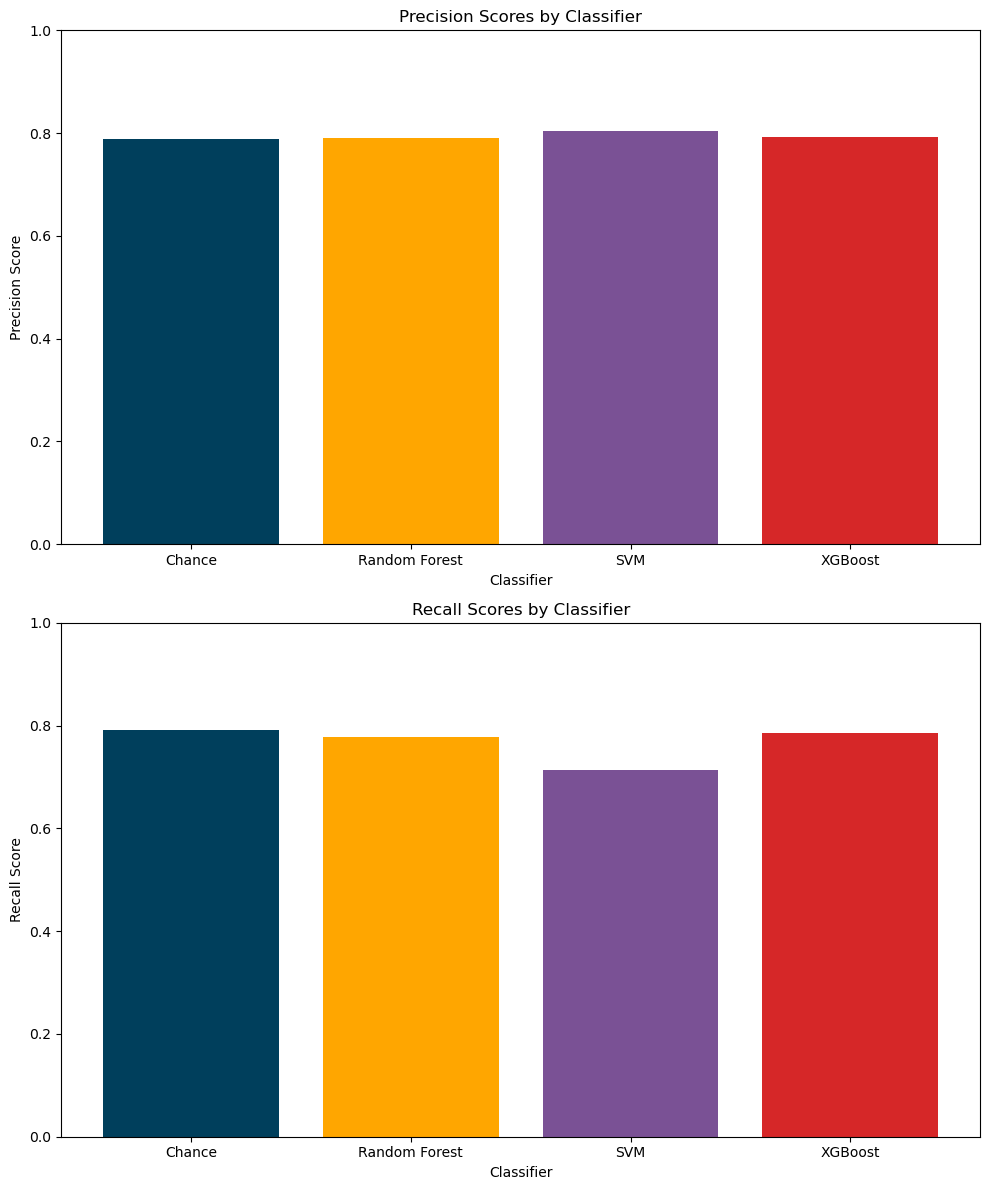

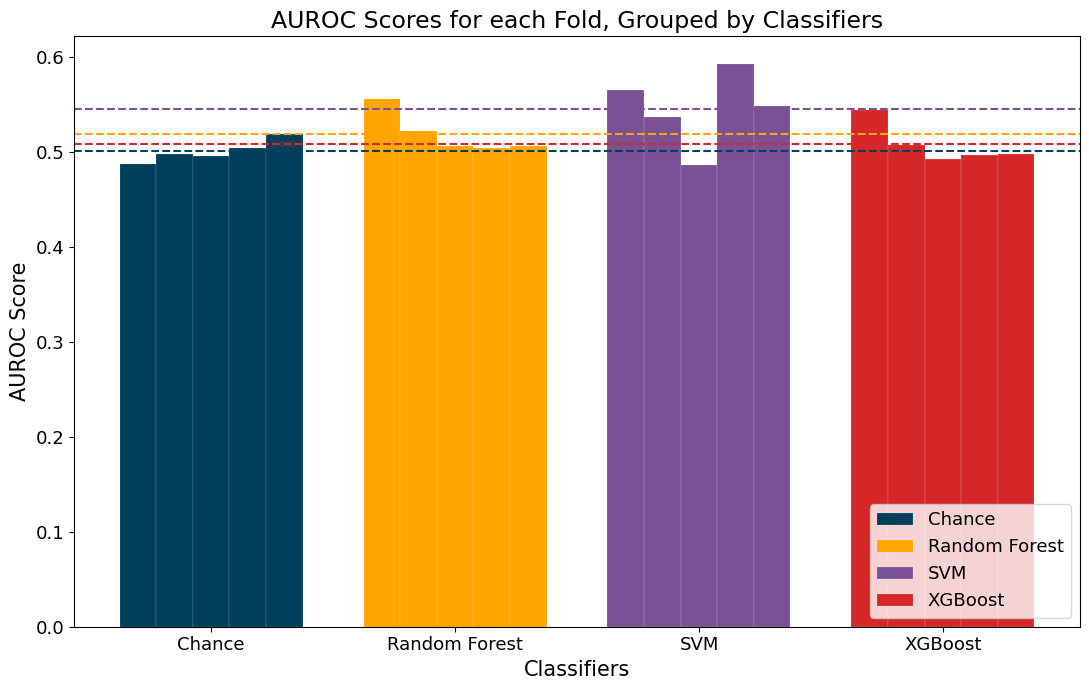

In [4]:
#AUROC
# Preparing the data
X = df_all_clean.drop(["Participant", "Question", "Correct", "Paragraph", "ParaText", "Probe", "sentiment", 
                "wordCount_with_stopwords", "syllableCount_with_stopwords", "ease_of_reading", "wordCount_without_stopwords", 
                "syllableCount_without_stopwords", "CD", "NN", "JJ", "VBN", "VBP", "NNS", "VBD", "VBG", "DT", "IN", "JJS", 
                "MD", "VB", "RB", "VBZ", "RBS", "JJR", "WRB", "RBR"], axis = 1)

y = df_all_clean['Correct']

# # Identify majority and minority classes
# majority_class = df_all_clean['TUT'].value_counts().idxmax()
# minority_class = df_all_clean['TUT'].value_counts().idxmin()
# print("Majority class", majority_class)
# print("Minority class", minority_class)

# # Separate majority and minority class samples
# majority_indices = df_all_clean[df_all_clean['TUT'] == majority_class].index
# minority_indices = df_all_clean[df_all_clean['TUT'] == minority_class].index

# precision_scorer = make_scorer(precision_score)

plt.figure(figsize=(11, 7)) 

precision_dict = {}
recall_dict = {}

# List of classifiers
classifiers = {
    'Chance': DummyClassifier(strategy="stratified"),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(random_state=42, probability=True), 
    "XGBoost": xgb.XGBClassifier(random_state=42)
}
auroc_score_barplot = {name: [] for name in classifiers}

# Fit PCA to determine the number of components that explain 95% of the variance
pca = PCA().fit(X)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
# print(f'Number of components that explain 95% of the variance: {n_components}')

# # Plot cumulative explained variance to visually inspect
# plt.figure(figsize=(10, 6))
# plt.plot(cumulative_variance, marker='o')
# plt.axhline(y=0.95, color='r', linestyle='--')
# plt.axvline(x=n_components - 1, color='r', linestyle='--')
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.title('Cumulative Explained Variance by Number of Components')
# plt.show()

# Parameters for tuning classifiers
param_grid_RF = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 100, 200],
    }

param_grid_SVM = {
    'C': [0.1, 1, 10],
#     'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear']
}
    

param_grid_XGB = {
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [10, 20],
    'min_child_weight': [1, 3, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
}

param_grids = {
    'Random Forest': param_grid_RF,
    'SVM': param_grid_SVM,
    'XGBoost': param_grid_XGB
}

# Define the number of folds for cross-validation
n_splits = 5

# Define the GroupKFold object
gkf = GroupKFold(n_splits=n_splits)

# Loop through the classifiers
for name, clf in classifiers.items():
    # Initialize lists to store evaluation metrics for each fold
    accuracy_scores = []
    weighted_f1_scores = []
    precision_scores = []
    recall_scores = []
    auroc_scores = []
    confusion_matrices = []
    prediction_rates = []

    # Perform cross-validation
    for train_index, test_index in gkf.split(X, y, groups=df_all_clean['Participant']):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply PCA on the training data
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i}' for i in range(X_train_pca.shape[1])])

        
        # Perform oversampling on minority class
        smote = SMOTE()
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca_df, y_train)

#         print(f"Before SMOTE: {Counter(y_train)}")
#         print(f"After SMOTE: {Counter(y_train_resampled)}")

        # Apply the transformation to the test data
        X_test_pca = pca.transform(X_test)
        X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i}' for i in range(X_test_pca.shape[1])])

        
        # Perform hyperparamenter tuning and train classifiers on best parameters
        if name != "Chance":
            grid = GridSearchCV(clf, param_grids[name], refit=True, verbose=3, scoring='roc_auc', n_jobs=-1)
            grid.fit(X_train_resampled, y_train_resampled)
            best_clf = grid.best_estimator_
            best_clf = best_clf.fit(X_train_resampled, y_train_resampled)
            # Perform prediction on test data
            y_pred = best_clf.predict(X_test_pca_df)

            # Calculating predicted probabilities for AUROC
            y_pred_proba = best_clf.predict_proba(X_test_pca_df)[:, 1] 

        else:
            best_clf = clf.fit(X_train, y_train)
            # Perform prediction on test data
            y_pred = best_clf.predict(X_test)

            # Calculating predicted probabilities for AUROC
            y_pred_proba = best_clf.predict_proba(X_test)[:, 1] 


        # Evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        weighted_f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)  
        recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
        auroc = roc_auc_score(y_test, y_pred_proba) 
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        prediction_rate = (confusion_matrix[1, 1] + confusion_matrix[0, 1]) / (confusion_matrix[1, 1] + confusion_matrix[1, 0] + confusion_matrix[0, 1] + confusion_matrix[0, 0])

        
        # Append evaluation metrics to lists
        accuracy_scores.append(accuracy)
        weighted_f1_scores.append(weighted_f1)
        precision_scores.append(precision)
        recall_scores.append(recall)
        auroc_scores.append(auroc)
        confusion_matrices.append(confusion_matrix)
        prediction_rates.append(prediction_rate)

        #barplot for AUROC
        auroc_score_barplot[name].append(auroc)
        
    
    # Calculate average evaluation metrics across all folds
    avg_accuracy = np.mean(accuracy_scores)
    avg_weighted_f1 = np.mean(weighted_f1_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_auroc = np.mean(auroc_scores)
    avg_confusion_matrix = np.mean(confusion_matrices, axis=0)
    avg_prediction_rate = np.mean(prediction_rates)

    
    # Output the average evaluation metrics for each classifier
    print(f"{name} Results:")
    print(f"Avg Accuracy: {avg_accuracy:.2f}")
    print(f"Avg Weighted F1 Score: {avg_weighted_f1:.2f}")
    print(f"Avg Precision_1: {avg_precision:.2f}")
    print(f"Avg Recall_1: {avg_recall:.2f}")
    print(f"Avg AUROC: {avg_auroc:.2f}")
    print("Avg Confusion Matrix:")
    print(avg_confusion_matrix)
    print(f"Avg Prediction Rate: {avg_prediction_rate:.2f}\n")

    # Store the average precision and recall for each classifier in a dictionary
    precision_dict[name] = avg_precision
    recall_dict[name] = avg_recall
    

# List of colors for each classifier
colors = ['#003F5C', '#FFA600', '#7A5195', '#D62728']

# Plot bar charts for precision and recall
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Precision plot
ax[0].bar(precision_dict.keys(), precision_dict.values(), color=colors)
ax[0].set_title('Precision Scores by Classifier')
ax[0].set_xlabel('Classifier')
ax[0].set_ylabel('Precision Score')
ax[0].set_ylim([0, 1])

# Recall plot
ax[1].bar(recall_dict.keys(), recall_dict.values(), color=colors)
ax[1].set_title('Recall Scores by Classifier')
ax[1].set_xlabel('Classifier')
ax[1].set_ylabel('Recall Score')
ax[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()


# Plot bar chart for AUROC
fig, ax = plt.subplots(figsize=(11, 7))
bar_width = 0.15  
gap_width = 0.05 

bar_positions = np.arange(len(classifiers)) * (n_splits * (bar_width + gap_width))

for idx, name in enumerate(classifiers):
    scores = auroc_score_barplot[name]
    avg_score = np.mean(scores)
    for fold_idx, score in enumerate(scores):
        bar_pos = bar_positions[idx] + (fold_idx * bar_width)
        ax.bar(bar_pos, score, bar_width, label=name if fold_idx == 0 else "",
               color=colors[idx], edgecolor='white', linewidth=0.1, alpha=1)
    ax.axhline(y=avg_score, color=colors[idx], linestyle='dashed', linewidth=1.5)
ax.set_xlabel('Classifiers', fontsize=15)
ax.set_ylabel('AUROC Score', fontsize=15)
ax.set_title('AUROC Scores for each Fold, Grouped by Classifiers', fontsize=17)

ax.set_xticks(bar_positions + ((n_splits * bar_width) / 2) - (bar_width / 2))
ax.set_xticklabels(classifiers.keys())

# Increasing the font size for tick labels and legend
ax.tick_params(axis='both', which='major', labelsize=13)


ax.legend(loc='lower right', fontsize=13)

plt.tight_layout()
plt.show()


### GAZE + FIXATION + QUESTION RESPONSE TIME + NLP

Chance Results:
Avg Accuracy: 0.67
Avg Weighted F1 Score: 0.67
Avg Precision_1: 0.79
Avg Recall_1: 0.80
Avg AUROC: 0.50
Avg Confusion Matrix:
[[ 59.8 207.6]
 [203.2 791.2]]
Avg Prediction Rate: 0.79

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Random Forest Results:
Avg Accuracy: 0.71
Avg Weighted F1 Score: 0.72
Avg Precision_1: 0.84
Avg Recall_1: 0.77
Avg AUROC: 0.69
Avg Confusion Matrix:
[[120.2 147.2]
 [223.8 770.6]]
Avg Prediction Rate: 0.73

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, t

<Figure size 1100x700 with 0 Axes>

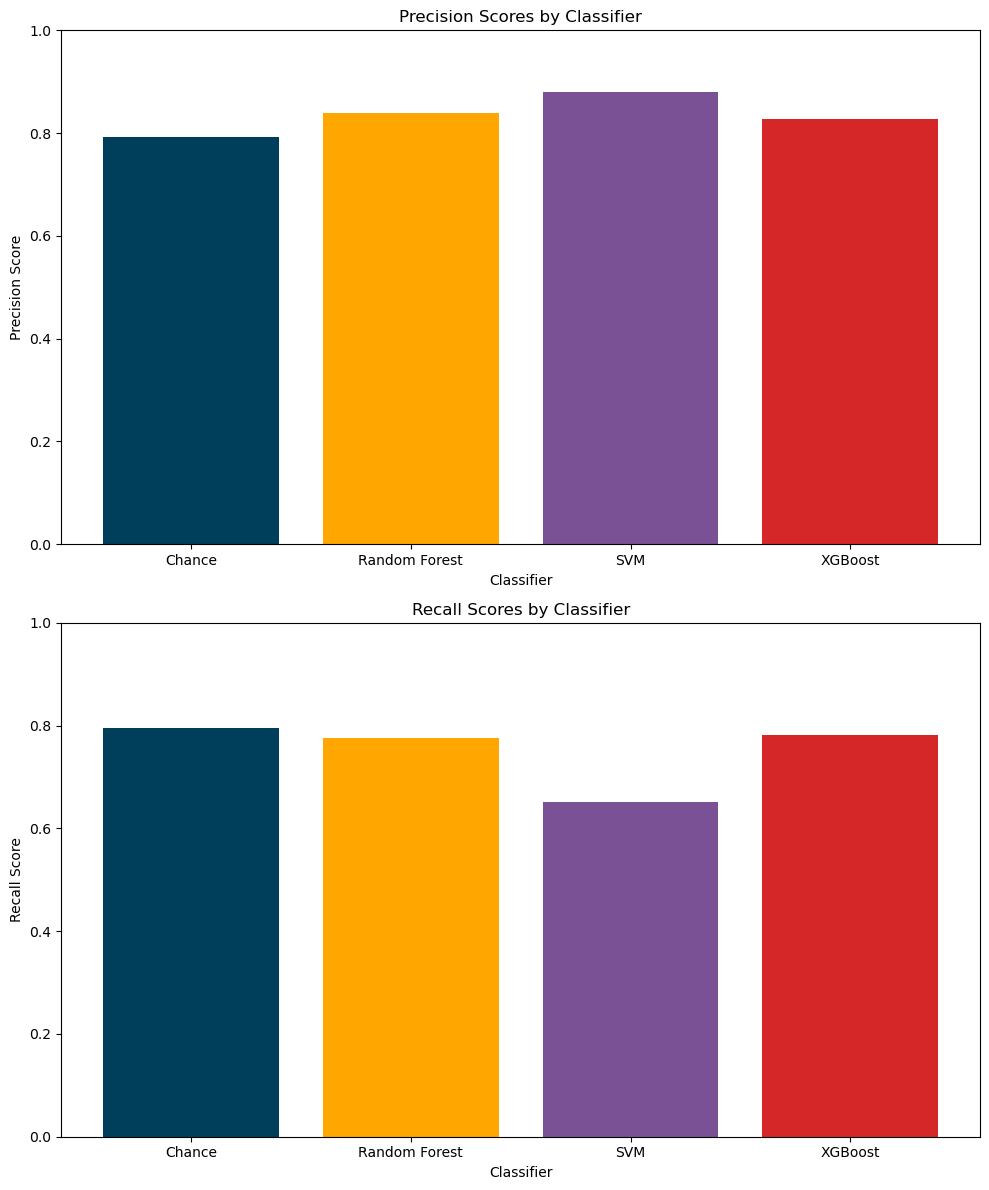

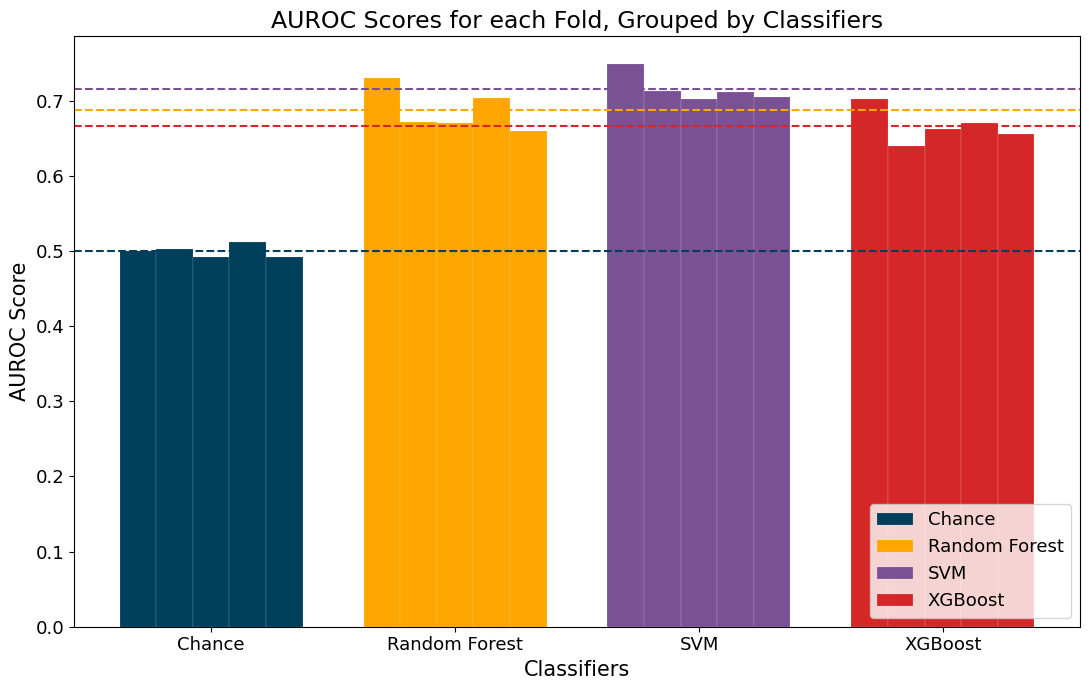

In [5]:
#AUROC
# Preparing the data
X = df_all_clean.drop(["Participant", "Question", "Correct", "Paragraph", "ParaText", "Probe"], axis = 1)

y = df_all_clean['Correct']

# # Identify majority and minority classes
# majority_class = df_all_clean['TUT'].value_counts().idxmax()
# minority_class = df_all_clean['TUT'].value_counts().idxmin()
# print("Majority class", majority_class)
# print("Minority class", minority_class)

# # Separate majority and minority class samples
# majority_indices = df_all_clean[df_all_clean['TUT'] == majority_class].index
# minority_indices = df_all_clean[df_all_clean['TUT'] == minority_class].index

# precision_scorer = make_scorer(precision_score)

plt.figure(figsize=(11, 7)) 

precision_dict = {}
recall_dict = {}

# List of classifiers
classifiers = {
    'Chance': DummyClassifier(strategy="stratified"),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(random_state=42, probability=True), 
    "XGBoost": xgb.XGBClassifier(random_state=42)
}
auroc_score_barplot = {name: [] for name in classifiers}

# Fit PCA to determine the number of components that explain 95% of the variance
pca = PCA().fit(X)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
# print(f'Number of components that explain 95% of the variance: {n_components}')

# # Plot cumulative explained variance to visually inspect
# plt.figure(figsize=(10, 6))
# plt.plot(cumulative_variance, marker='o')
# plt.axhline(y=0.95, color='r', linestyle='--')
# plt.axvline(x=n_components - 1, color='r', linestyle='--')
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.title('Cumulative Explained Variance by Number of Components')
# plt.show()

# Parameters for tuning classifiers
param_grid_RF = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 100, 200],
    }

param_grid_SVM = {
    'C': [0.1, 1, 10],
#     'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear']
}
    

param_grid_XGB = {
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [10, 20],
    'min_child_weight': [1, 3, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
}

param_grids = {
    'Random Forest': param_grid_RF,
    'SVM': param_grid_SVM,
    'XGBoost': param_grid_XGB
}

# Define the number of folds for cross-validation
n_splits = 5

# Define the GroupKFold object
gkf = GroupKFold(n_splits=n_splits)

# Loop through the classifiers
for name, clf in classifiers.items():
    # Initialize lists to store evaluation metrics for each fold
    accuracy_scores = []
    weighted_f1_scores = []
    precision_scores = []
    recall_scores = []
    auroc_scores = []
    confusion_matrices = []
    prediction_rates = []

    # Perform cross-validation
    for train_index, test_index in gkf.split(X, y, groups=df_all_clean['Participant']):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply PCA on the training data
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i}' for i in range(X_train_pca.shape[1])])

        
        # Perform oversampling on minority class
        smote = SMOTE()
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca_df, y_train)

#         print(f"Before SMOTE: {Counter(y_train)}")
#         print(f"After SMOTE: {Counter(y_train_resampled)}")

        # Apply the transformation to the test data
        X_test_pca = pca.transform(X_test)
        X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i}' for i in range(X_test_pca.shape[1])])

        
        # Perform hyperparamenter tuning and train classifiers on best parameters
        if name != "Chance":
            grid = GridSearchCV(clf, param_grids[name], refit=True, verbose=3, scoring='roc_auc', n_jobs=-1)
            grid.fit(X_train_resampled, y_train_resampled)
            best_clf = grid.best_estimator_
            best_clf = best_clf.fit(X_train_resampled, y_train_resampled)
            # Perform prediction on test data
            y_pred = best_clf.predict(X_test_pca_df)

            # Calculating predicted probabilities for AUROC
            y_pred_proba = best_clf.predict_proba(X_test_pca_df)[:, 1] 

        else:
            best_clf = clf.fit(X_train, y_train)
            # Perform prediction on test data
            y_pred = best_clf.predict(X_test)

            # Calculating predicted probabilities for AUROC
            y_pred_proba = best_clf.predict_proba(X_test)[:, 1] 


        # Evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        weighted_f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)  
        recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
        auroc = roc_auc_score(y_test, y_pred_proba) 
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        prediction_rate = (confusion_matrix[1, 1] + confusion_matrix[0, 1]) / (confusion_matrix[1, 1] + confusion_matrix[1, 0] + confusion_matrix[0, 1] + confusion_matrix[0, 0])

        
        # Append evaluation metrics to lists
        accuracy_scores.append(accuracy)
        weighted_f1_scores.append(weighted_f1)
        precision_scores.append(precision)
        recall_scores.append(recall)
        auroc_scores.append(auroc)
        confusion_matrices.append(confusion_matrix)
        prediction_rates.append(prediction_rate)

        #barplot for AUROC
        auroc_score_barplot[name].append(auroc)
        
    
    # Calculate average evaluation metrics across all folds
    avg_accuracy = np.mean(accuracy_scores)
    avg_weighted_f1 = np.mean(weighted_f1_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_auroc = np.mean(auroc_scores)
    avg_confusion_matrix = np.mean(confusion_matrices, axis=0)
    avg_prediction_rate = np.mean(prediction_rates)

    
    # Output the average evaluation metrics for each classifier
    print(f"{name} Results:")
    print(f"Avg Accuracy: {avg_accuracy:.2f}")
    print(f"Avg Weighted F1 Score: {avg_weighted_f1:.2f}")
    print(f"Avg Precision_1: {avg_precision:.2f}")
    print(f"Avg Recall_1: {avg_recall:.2f}")
    print(f"Avg AUROC: {avg_auroc:.2f}")
    print("Avg Confusion Matrix:")
    print(avg_confusion_matrix)
    print(f"Avg Prediction Rate: {avg_prediction_rate:.2f}\n")

    # Store the average precision and recall for each classifier in a dictionary
    precision_dict[name] = avg_precision
    recall_dict[name] = avg_recall
    

# List of colors for each classifier
colors = ['#003F5C', '#FFA600', '#7A5195', '#D62728']

# Plot bar charts for precision and recall
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Precision plot
ax[0].bar(precision_dict.keys(), precision_dict.values(), color=colors)
ax[0].set_title('Precision Scores by Classifier')
ax[0].set_xlabel('Classifier')
ax[0].set_ylabel('Precision Score')
ax[0].set_ylim([0, 1])

# Recall plot
ax[1].bar(recall_dict.keys(), recall_dict.values(), color=colors)
ax[1].set_title('Recall Scores by Classifier')
ax[1].set_xlabel('Classifier')
ax[1].set_ylabel('Recall Score')
ax[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()


# Plot bar chart for AUROC
fig, ax = plt.subplots(figsize=(11, 7))
bar_width = 0.15  
gap_width = 0.05 

bar_positions = np.arange(len(classifiers)) * (n_splits * (bar_width + gap_width))

for idx, name in enumerate(classifiers):
    scores = auroc_score_barplot[name]
    avg_score = np.mean(scores)
    for fold_idx, score in enumerate(scores):
        bar_pos = bar_positions[idx] + (fold_idx * bar_width)
        ax.bar(bar_pos, score, bar_width, label=name if fold_idx == 0 else "",
               color=colors[idx], edgecolor='white', linewidth=0.1, alpha=1)
    ax.axhline(y=avg_score, color=colors[idx], linestyle='dashed', linewidth=1.5)
ax.set_xlabel('Classifiers', fontsize=15)
ax.set_ylabel('AUROC Score', fontsize=15)
ax.set_title('AUROC Scores for each Fold, Grouped by Classifiers', fontsize=17)

ax.set_xticks(bar_positions + ((n_splits * bar_width) / 2) - (bar_width / 2))
ax.set_xticklabels(classifiers.keys())

# Increasing the font size for tick labels and legend
ax.tick_params(axis='both', which='major', labelsize=13)


ax.legend(loc='lower right', fontsize=13)

plt.tight_layout()
plt.show()
